## Image Classification using Convolutional Neural Networks 

In this example we will use Keras to build a deep Convolutional Neural Network (CNN) and train it on the CIFAR-100 dataset.

After 100 training epochs, this network scores ~66% top-1 accuracy on the dataset's test-set.


### Preparations

First, lets import all the modules we use below.

In [1]:
# load all the modules we use below
from six.moves import cPickle
import os

import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar100
from keras.engine.training import Model
from keras.layers import Add, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, Input
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


Next, we need to download and load the CIFAR-100 dataset. Luckily, Keras has a built-in module that deals with that, so all we have to do is use it to load the dataset, and preprocess it to fit our training process.

In [2]:
# input image dimensions (32x32x3)
HEIGHT, WIDTH, DEPTH = 32, 32, 3

# CIFAR-100 consists of 100 fine classes, and 20 coarse classes.
N_CLASSES = 100


def load_dataset():
    # load the CIFAR-100 dataset, along with the fine class labels.
    (x_train, y_train), (x_test, y_test) = cifar100.load_data('fine')

    # transform the inputs to range [-1, 1].
    x_train = x_train.astype('float32')
    x_train = (x_train - 127.5) / 127.5
    x_test = x_test.astype('float32')
    x_test = (x_test - 127.5) / 127.5

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, N_CLASSES)
    y_test = keras.utils.to_categorical(y_test, N_CLASSES)

    return (x_train, y_train), (x_test, y_test)


We can now load the dataset.


In [3]:
(x_train, y_train), (x_test, y_test) = load_dataset()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 100) (10000, 32, 32, 3) (10000, 100)


Notice that we have 50,000 images in our training set, and 10,000 images in out test set. 
Each image is of dimension 32x32 and has three color channels (RGB).
Let's take a look at how these images look like:

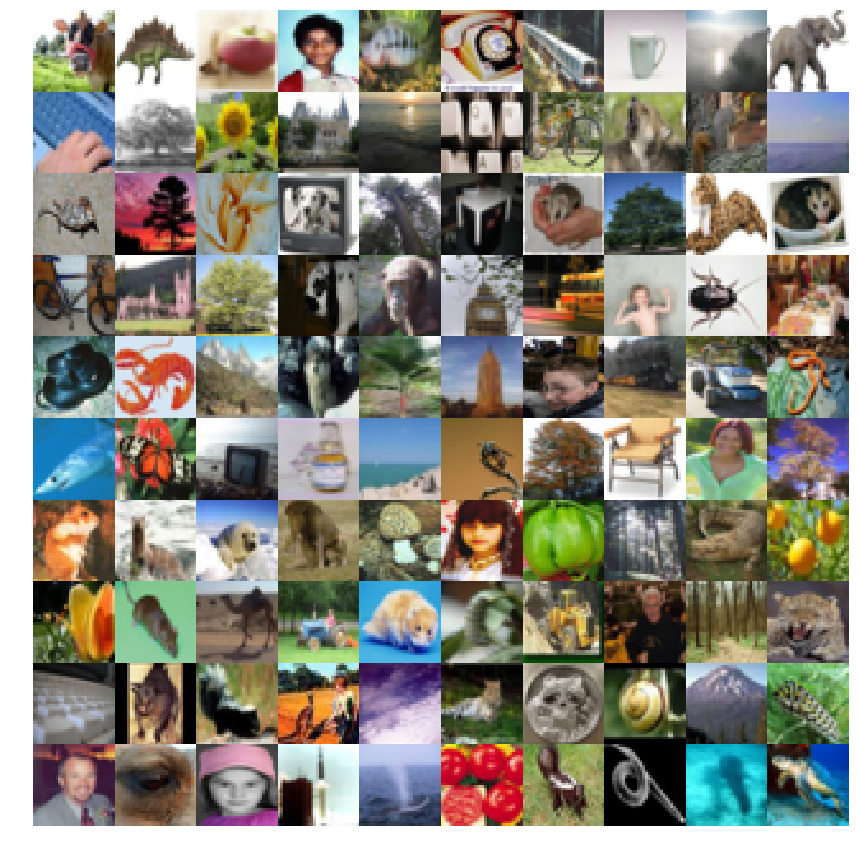

In [4]:
def plot_images(images, n_images):
    _, h, w, d = images.shape
    # create an array that will store the images to plot.
    canvas = np.empty((h * n_images, w * n_images, d), dtype='uint8')

    for i in range(n_images):
        img_column = images[i * n_images:(i + 1) * n_images]
        for j in range(n_images):
            if j >= img_column.shape[0]:
                break

            # transform images to the range [0, 255]
            img = img_column[j]
            img = ((img * 127.5) + 127.5).clip(0, 255).astype('uint8')            
            canvas[i * h:(i + 1) * h, j * w:(j + 1) * w] = img

    plt.figure(figsize=(1.5 * n_images, 1.5 * n_images))
    plt.axis('off')
    cmap = 'gray' if d == 1 else None
    plt.imshow(canvas.squeeze(), origin="upper", cmap=cmap)
    plt.show()


plot_images(x_train, 10)

Pretty blurry, but nice.

### Building the Model

Next, lets build our CNN model. We will use the classic structure of multiple convolutional blocks, each consisting on two Convolutional layers, followed by a Max-Pooling layer and a Dropout layer. We will use a total of four such Convolutional blocks. After the convolutional blocks, we will use two Fully-Connected layers to perform the final classification. For non-linearities, we will use the ELU activation.

We will also add a Batch-Normalization layer to normalize the outputs of all other layers, this has mulitple advantages including regularization, and a significant training speedup (iterations-wise).


In [5]:
def build_classifier_model():
    n_conv_blocks = 4  # number of convolution blocks to have in our model.
    n_filters = 32  # number of filters to use in the first convolution block.
    l2_reg = regularizers.l2(2e-4)  # weight to use for L2 weight decay. 
    activation = 'elu'  # the activation function to use after each linear operation.

    if K.image_data_format() == 'channels_first':
        input_shape = (3, HEIGHT, WIDTH)
    else:
        input_shape = (HEIGHT, WIDTH, 3)

    x = input_1 = Input(shape=input_shape)
    
    # each convolution block consists of two sub-blocks of Conv->Batch-Normalization->Activation,
    # followed by a Max-Pooling and a Dropout layer.
    for i in range(n_conv_blocks):
        x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2_reg)(x)
        x = BatchNormalization()(x)
        x = Activation(activation=activation)(x)
        
        x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2_reg)(x)
        x = BatchNormalization()(x)        
        x = Activation(activation=activation)(x)
        
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(rate=0.25)(x)
        
        n_filters *= 2

    # finally, we flatten the output of the last convolution block, and add two Fully-Connected layers.
    x = Flatten()(x)
    x = Dense(units=512, kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = Activation(activation=activation)(x)

    x = Dropout(rate=0.5)(x)
    x = Dense(units=N_CLASSES, kernel_regularizer=l2_reg)(x)
    output = Activation(activation='softmax')(x)

    return Model(inputs=[input_1], outputs=[output])


model = build_classifier_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
__________

By calling the model's summary function, we get a nice printout of our network's structure, including the total number of trainable parameters (~1.7M trainable parameters in our case).

### Training the Model

Next, we will train our model on our training set. We will use mini-batches of 128 images, and a total of 100 epochs.
As an optimizer we will use Adam with an initial learning rate of 0.002. We will also use a learning-rate schedule in which the learning-rate will be reduced by a factor of two when reaching epochs 20, 40, 50, 60, 70, 80 and 90.
As a loss function we will use categorical cross-entropy, which suites our multi-class classification problem.

In [6]:
def train_classifier(model_output_path=None, batch_size=128, epochs=100, initial_lr=2e-3):    
    def lr_scheduler(epoch):
        if epoch < 20:
            return initial_lr
        elif epoch < 40:
            return initial_lr / 2
        elif epoch < 50:
            return initial_lr / 4
        elif epoch < 60:
            return initial_lr / 8
        elif epoch < 70:
            return initial_lr / 16
        elif epoch < 80:
            return initial_lr / 32
        elif epoch < 90:
            return initial_lr / 64
        else:
            return initial_lr / 128

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(initial_lr),
        metrics=['accuracy']
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(x_test, y_test),
        callbacks=[LearningRateScheduler(lr_scheduler)]
    )

    if model_output_path is not None:
        print('saving trained model to:', model_output_path)
        model.save(model_output_path)
        
    return history


history = train_classifier()


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 27s - loss: 4.2606 - acc: 0.1203 - val_loss: 3.9106 - val_acc: 0.1719
Epoch 2/100
 - 26s - loss: 3.4536 - acc: 0.2396 - val_loss: 3.1769 - val_acc: 0.2949
Epoch 3/100
 - 26s - loss: 3.1106 - acc: 0.3098 - val_loss: 2.9638 - val_acc: 0.3452
Epoch 4/100
 - 26s - loss: 2.9344 - acc: 0.3569 - val_loss: 2.7100 - val_acc: 0.4079
Epoch 5/100
 - 26s - loss: 2.8317 - acc: 0.3877 - val_loss: 2.7024 - val_acc: 0.4272
Epoch 6/100
 - 26s - loss: 2.7614 - acc: 0.4125 - val_loss: 2.6373 - val_acc: 0.4514
Epoch 7/100
 - 26s - loss: 2.7225 - acc: 0.4317 - val_loss: 2.6092 - val_acc: 0.4611
Epoch 8/100
 - 26s - loss: 2.6838 - acc: 0.4455 - val_loss: 2.5722 - val_acc: 0.4789
Epoch 9/100
 - 26s - loss: 2.6617 - acc: 0.4577 - val_loss: 2.6310 - val_acc: 0.4752
Epoch 10/100
 - 26s - loss: 2.6422 - acc: 0.4669 - val_loss: 2.5735 - val_acc: 0.4933
Epoch 11/100
 - 26s - loss: 2.6214 - acc: 0.4807 - val_loss: 2.5840 - val_acc: 0.5008
Epoch 12/100


Epoch 96/100
 - 26s - loss: 0.5638 - acc: 0.9625 - val_loss: 1.9898 - val_acc: 0.6568
Epoch 97/100
 - 26s - loss: 0.5670 - acc: 0.9605 - val_loss: 1.9915 - val_acc: 0.6569
Epoch 98/100
 - 26s - loss: 0.5629 - acc: 0.9611 - val_loss: 1.9884 - val_acc: 0.6562
Epoch 99/100
 - 26s - loss: 0.5622 - acc: 0.9607 - val_loss: 1.9909 - val_acc: 0.6560
Epoch 100/100
 - 26s - loss: 0.5590 - acc: 0.9623 - val_loss: 1.9856 - val_acc: 0.6569


Let's plot our model's training loss and top-1 accuracy, as a function of the training epoch number.

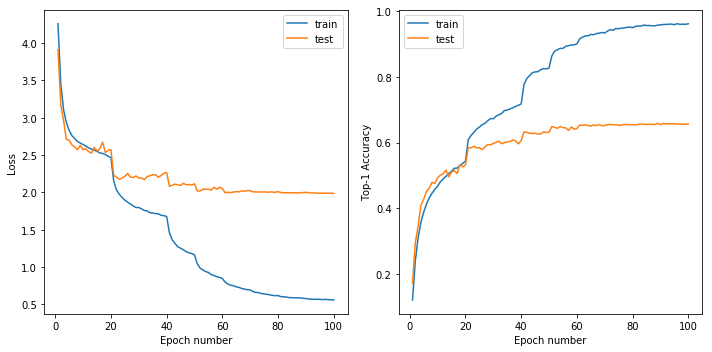

In [7]:
def plot_training_history(history):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = len(loss)
    
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].plot(np.arange(1, epochs + 1), loss, label='train')
    axs[0].plot(np.arange(1, epochs + 1), val_loss, label='test')
    axs[0].set_xlabel('Epoch number')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc="best")

    acc, val_acc = history.history['acc'], history.history['val_acc']
    axs[1].plot(np.arange(1, epochs + 1), acc, label='train')
    axs[1].plot(np.arange(1, epochs + 1), val_acc, label='test')
    axs[1].set_xlabel('Epoch number')
    axs[1].set_ylabel('Top-1 Accuracy')
    axs[1].legend(loc="best")
    
    plt.tight_layout()
    plt.show()
    
    
plot_training_history(history)


### Evaluating the Model

First, let's evaluate our model on the train and test sets.

In [8]:
print('Train-set performance --> loss: {:.4f}, accuracy: {:.4f}'.format(*model.evaluate(x_train, y_train, verbose=0)))
print('Test-set performance --> loss: {:.4f}, accuracy: {:.4f}'.format(*model.evaluate(x_test, y_test, verbose=0)))


Train-set performance --> loss: 0.4358, accuracy: 0.9995
Test-set performance --> loss: 1.9856, accuracy: 0.6569


Finally, let's manual-test our trained model against an arbitrary image from the test set.

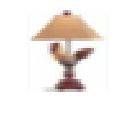

lamp: 100.0%, cup: 0.0%, table: 0.0%, whale: 0.0%, rocket: 0.0%


In [9]:
def load_label_names():
    dirname = 'cifar-100-python'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
    path = keras.utils.get_file(dirname, origin=origin, untar=True)

    fpath = os.path.join(path, 'meta')
    label_names = cPickle.load((open(fpath, 'rb')), encoding='bytes')
    label_names = [name.decode('ascii') for name in label_names[b'fine_label_names']]
    label_names = np.array(label_names)
    return label_names


label_names = load_label_names()


def get_prediction(x, top_n=5):
    predictions = model.predict(x)[0]
    predictions *= 100
    order = np.argsort(predictions)[::-1]
    sorted_predictions = list(zip(label_names[order], predictions[order]))
    print(', '.join(['{}: {:.1f}%'.format(label, confidence) for label, confidence in sorted_predictions[:top_n]]))


img = x_test[14, np.newaxis]
plot_images(img, 1)
get_prediction(img)

Yes, this is indeed a lamp. Cool!

For more Keras examples, see my [GitHub repository](https://github.com/matanby/keras-examples)